# Notebook for benchmarking different variational approaches in solving a QUBO

In [1]:
from aquapointer.digital.loaddata import LoadData
from aquapointer.digital.qubo import Qubo
from aquapointer.digital.vqe import VQE
from aquapointer.digital.ansatz import QAOA_ansatz

# General imports
import numpy as np
import pickle

# Pre-defined ansatz circuit, operator class
from qiskit.circuit.library import QAOAAnsatz, TwoLocal
from qiskit.primitives import BackendSampler
from qiskit import QuantumCircuit, transpile 
from qiskit_aer import AerSimulator

backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

In [2]:
# LoadData does all the file loading
ld = LoadData()

# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from LoadData.
q = Qubo(ld)

In [3]:
# use the first slice as an example to solve
qubo, ising_ham = q.qubo_hamiltonian_pairs[1]
num_qubits = len(qubo)

# TwoLocal ansatz circuit
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
qubo

array([[-0.02881146,  0.04727714,  0.04727714,  0.03218907,  0.03218907,
         0.02656055,  0.01492186,  0.01492186,  0.00570776],
       [ 0.04727714, -0.03523304,  0.04727714,  0.04727714,  0.02656055,
         0.03218907,  0.01015968,  0.01492185,  0.00470971],
       [ 0.04727714,  0.04727714, -0.04167669,  0.04727714,  0.04727714,
         0.04727714,  0.02656054,  0.03218904,  0.0149218 ],
       [ 0.03218907,  0.04727714,  0.04727714, -0.03632582,  0.03218907,
         0.04727711,  0.01492184,  0.02656045,  0.01015953],
       [ 0.03218907,  0.02656055,  0.04727714,  0.03218907, -0.03937356,
         0.04727711,  0.0472771 ,  0.04727697,  0.03218859],
       [ 0.02656055,  0.03218907,  0.04727714,  0.04727711,  0.04727711,
        -0.04088436,  0.03218895,  0.04727645,  0.02655908],
       [ 0.01492186,  0.01015968,  0.02656054,  0.01492184,  0.0472771 ,
         0.03218895, -0.03256398,  0.04727644,  0.04727444],
       [ 0.01492186,  0.01492185,  0.03218904,  0.02656045,  0

In [4]:
#helper function to get number of basis gates used in ansatz
def total_gates(ansatz):
    basis_gates=['u1', 'u2', 'u3', 'cx']

    ansatz_transpiled = transpile(ansatz, backend, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=2)
    gates = ansatz_transpiled.count_ops()
    depth = ansatz_transpiled.depth()
    num_params = ansatz.num_parameters

    total_gates = 0
    for gate in basis_gates:
        total_gates += gates.get(gate, 0)
    return total_gates, depth, num_params

# Resource estimation/performance

In [5]:
# depth * number_of_params * maxiter is the same for both approaches, this makes a fair comparison in performance

In [6]:
# EXAMPLE: QAQA with warm start
np.random.seed(1)

qaoa_ansatz = QAOA_ansatz(qubo=qubo)

alpha = 0.7
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

vqe_qaoa.run(alpha=alpha, maxiter=10)
vqe_qaoa.history

[['010000001', 0.002, -0.05676551209085727],
 ['010000001', 0.6096, -0.05676551209085727],
 ['010000001', 0.6178, -0.05676551209085727],
 ['100100100', 0.0001, 0.02636427019305203],
 ['010000001', 0.517, -0.05676551209085727],
 ['010000001', 0.1222, -0.05676551209085727],
 ['010000001', 0.6318, -0.05676551209085727],
 ['010000001', 0.9945, -0.05676551209085727],
 ['010000001', 0.8428, -0.05676551209085727],
 ['010000001', 0.948, -0.05676551209085727]]

In [7]:
# let us first list the optimal solutions for the qubo problems using the classical brute force approach
optimal_solutions = []

for qubo in q.qubo_hamiltonian_pairs:
    # classical brute-force solution
    solution = q.find_optimum(qubo=qubo[0])
    optimal_solutions.append(solution)

optimal_solutions

[('1000', -0.010743767178636635),
 ('010000001', -0.05676551209085727),
 ('10001000000001', -0.07861404665042948),
 ('10000000100100', -0.07111143020268126),
 ('0000010100000', -0.05195638819992217),
 ('00010000', -0.02404680978135616)]

In [8]:
np.random.seed(1)

# now we solve all the qubo's and output optimal bitstrings of for each slice using QAOA and twolocal ansatz
alphas = [1.0, 0.75, 0.5, 0.25]
maxiter = 20
num_mc = 10

res_qaoa_slices_peralpha = []
res_linear_slices_peralpha = []

# If you haved the data from a previous run, set this to true. Else set it to false and it will run and save the data.
saved_data = True

if not saved_data:
    for alpha in alphas:
        print(f'alpha={alpha}')
        res_qaoa_slices = []
        res_linear_slices = []

        i = 0

        for qubo, ising_ham in q.qubo_hamiltonian_pairs:
            num_qubits = len(qubo)
            opt_sol = optimal_solutions[i]
            res_qaoa = []
            res_linear = []
            # print(f"slice {i}")
            i+=1
            
            # define the ansatzes
            # qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)
            qaoa_ansatz = QAOA_ansatz(qubo=qubo)
            beta  = [0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
            gamma = [0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
            params_qaoa = np.array(beta+gamma)

            # LE ansatz circuit
            le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
            params_linear = np.array([np.random.random()]*le_ansatz.num_parameters)

            # to keep it fair, we want depth * number_of_params * maxiter to be the same for both instances
            resources_qaoa, resources_linear = total_gates(qaoa_ansatz), total_gates(le_ansatz)
            iter_factor = (resources_qaoa[1]/resources_linear[1]) * (resources_qaoa[2]/resources_linear[2])
            maxiter_qaoa = maxiter
            maxiter_linear = int(maxiter_qaoa * iter_factor)

            histories_qaoa = []
            histories_linear = []

            vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params_qaoa, prob_opt_sol=True)
            for _ in range(num_mc):
                vqe_qaoa.params = params_qaoa
                vqe_qaoa.history = []

                vqe_qaoa.run(alpha=alpha, maxiter=maxiter_qaoa)
                history = vqe_qaoa.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter_qaoa-L):
                    history.append(last)

                histories_qaoa.append(history)

            vqe_linear = VQE(qubo=qubo, ansatz=le_ansatz, sampler=sampler, params=params_linear, prob_opt_sol=True)
            for _ in range(num_mc):
                vqe_linear.params = params_linear
                vqe_linear.history = []

                vqe_linear.run(alpha=alpha, maxiter=maxiter_linear)
                history = vqe_linear.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter_linear-L):
                    history.append(last)

                histories_linear.append(history)

            res_qaoa_slices.append(histories_qaoa)
            res_linear_slices.append(histories_linear)
        res_qaoa_slices_peralpha.append(res_qaoa_slices)
        res_linear_slices_peralpha.append(res_linear_slices)

    with open('qaoa_linear_res_ws.pkl', 'wb') as handle:
            pickle.dump((res_qaoa_slices_peralpha, res_linear_slices_peralpha, alphas), handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(f'qaoa_linear_res_ws.pkl', 'rb') as handle:
        a = pickle.load(handle)
        res_qaoa_slices_peralpha, res_linear_slices_peralpha = a[0], a[1]

alpha=1.0
alpha=0.75
alpha=0.5
alpha=0.25


In [9]:
# extract the probability of optimal solution from the results
prob_opt_sol_qaoa_peralpha = []
prob_opt_sol_linear_peralpha = []
for k in range(len(alphas)):
    prob_opt_sol_qaoa = []

    for slice in range(6):
        probs_perslice = np.zeros((num_mc, len(res_qaoa_slices_peralpha[k][slice][0])))
        for i in range(num_mc):
            for j in range(len(res_qaoa_slices_peralpha[k][slice][i])):
                
                if res_qaoa_slices_peralpha[k][slice][i][j][0] == optimal_solutions[slice][0]:
                    probs_perslice[i][j] = res_qaoa_slices_peralpha[k][slice][i][j][1]

        prob_opt_sol_qaoa.append(probs_perslice)

    prob_opt_sol_linear = []

    for slice in range(6):
        probs_perslice = np.zeros((num_mc, len(res_linear_slices_peralpha[k][slice][0])))
        for i in range(num_mc):
            for j in range(len(res_linear_slices_peralpha[k][slice][i])):
                if res_linear_slices_peralpha[k][slice][i][j][0] == optimal_solutions[slice][0]:
                    probs_perslice[i][j] = res_linear_slices_peralpha[k][slice][i][j][1]

        prob_opt_sol_linear.append(probs_perslice)
    prob_opt_sol_linear_peralpha.append(prob_opt_sol_linear)
    prob_opt_sol_qaoa_peralpha.append(prob_opt_sol_qaoa)


## Comparison of QAOA ansatz for different values of alpha

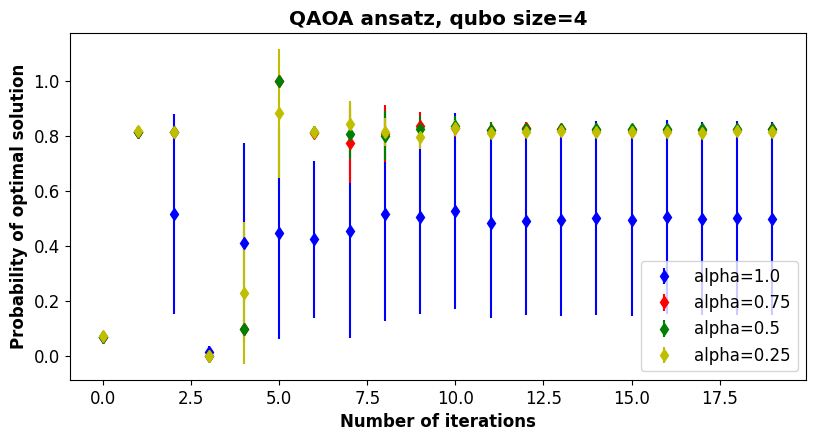

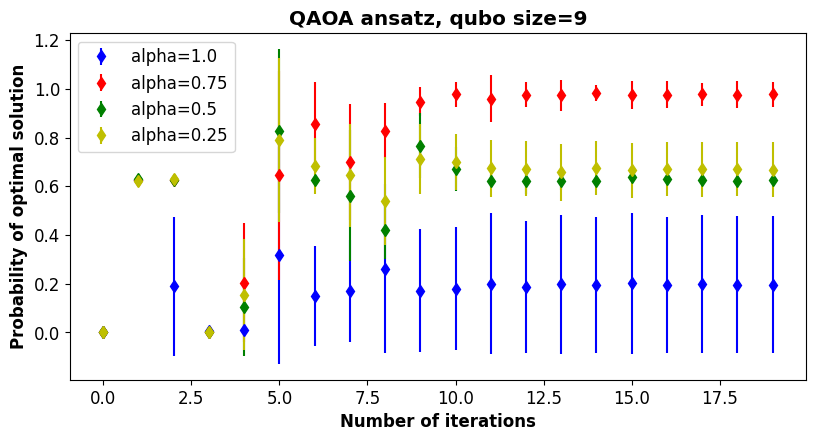

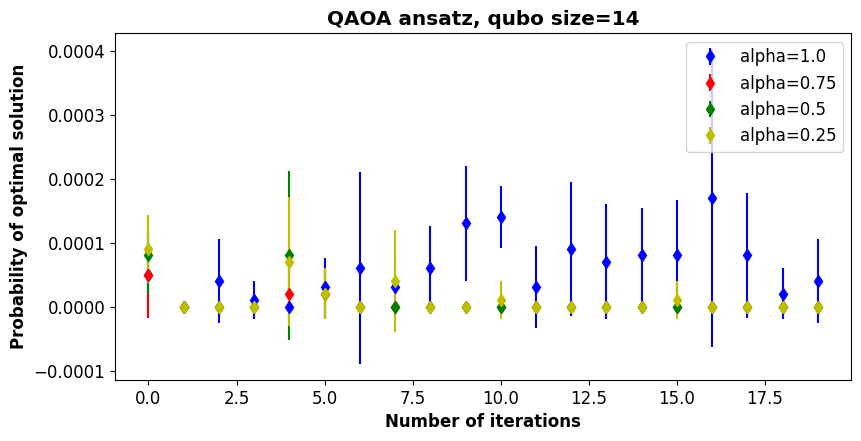

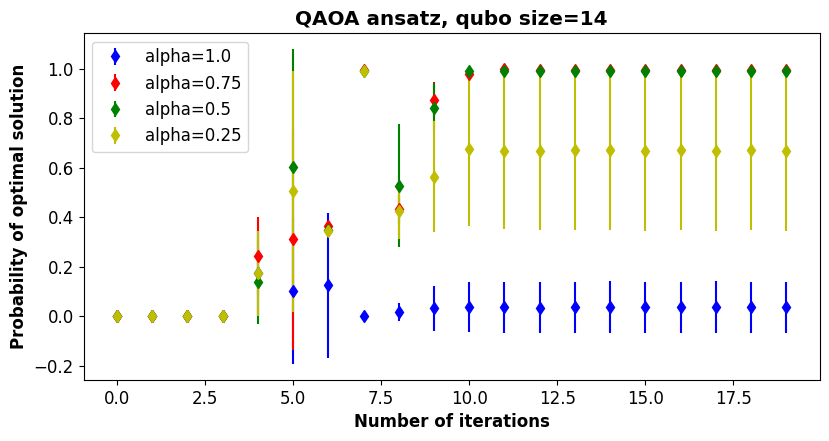

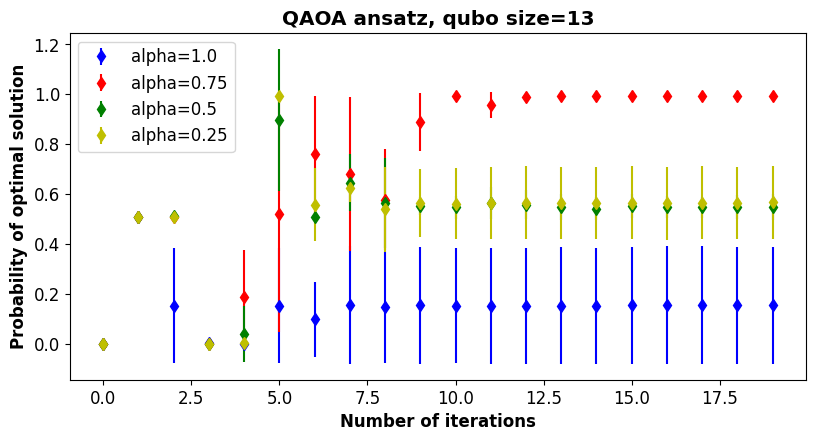

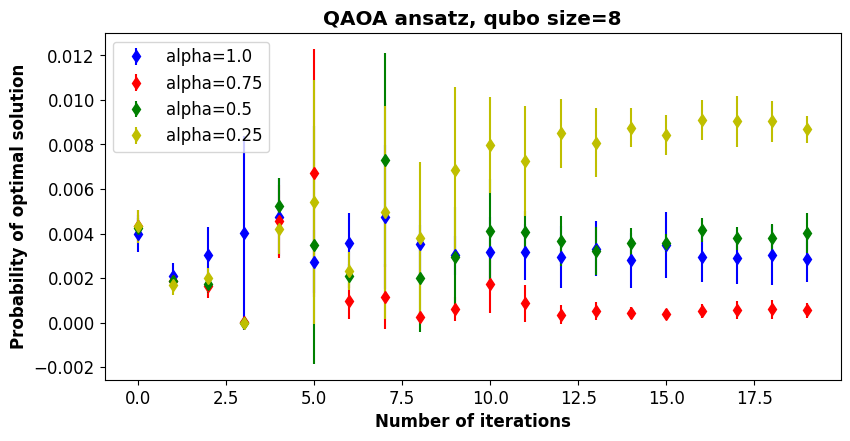

In [10]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

c = ['b', 'r', 'g', 'y', 'c']

for slice in range(6):
    plt.figure()
    for i in range(len(alphas)):
        number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa_peralpha[i][slice][0])))
        errorbar_qaoa = np.std(prob_opt_sol_qaoa_peralpha[i][slice], axis=0)
        plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa_peralpha[i][slice], axis=0), yerr=errorbar_qaoa, fmt=f'd{c[i]}', label=f'alpha={alphas[i]}')

    plt.legend()
    plt.title(f'QAOA ansatz, qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')


## Comparison of LE ansatz for different values of alpha

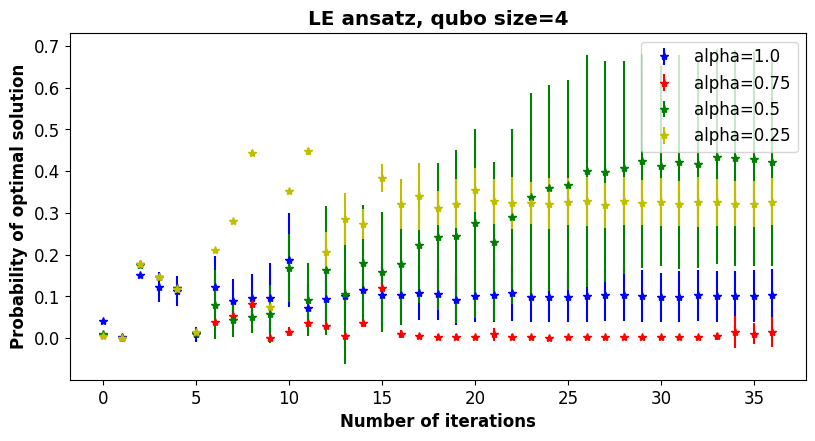

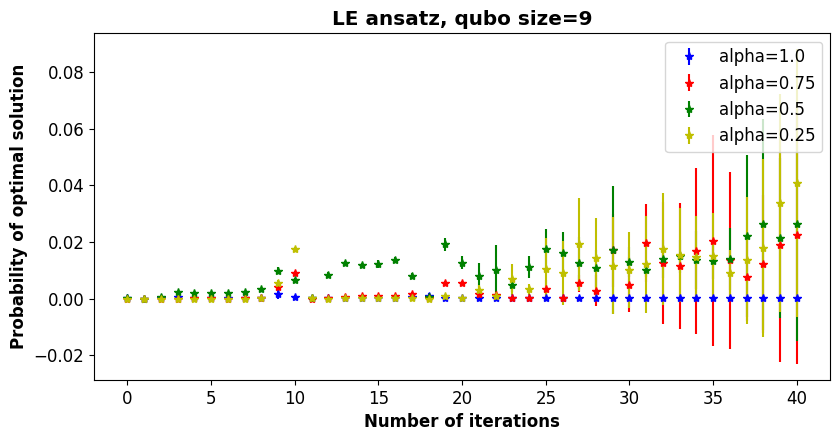

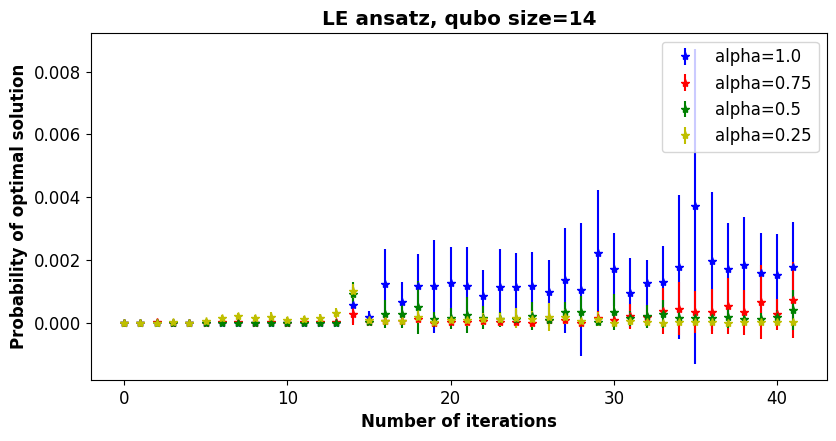

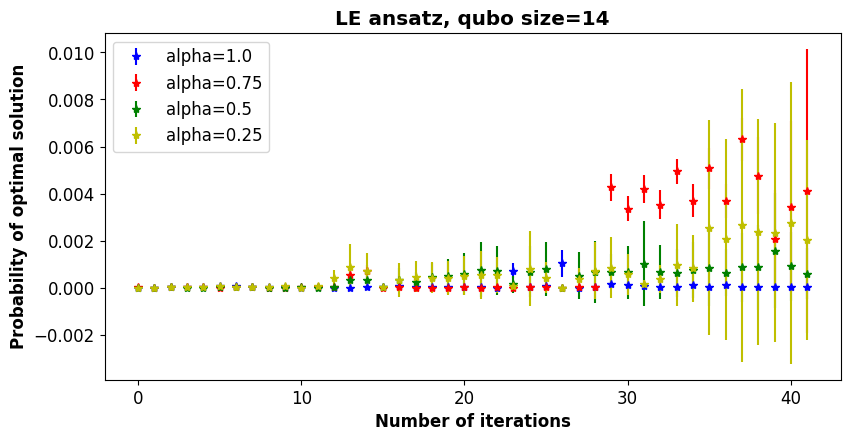

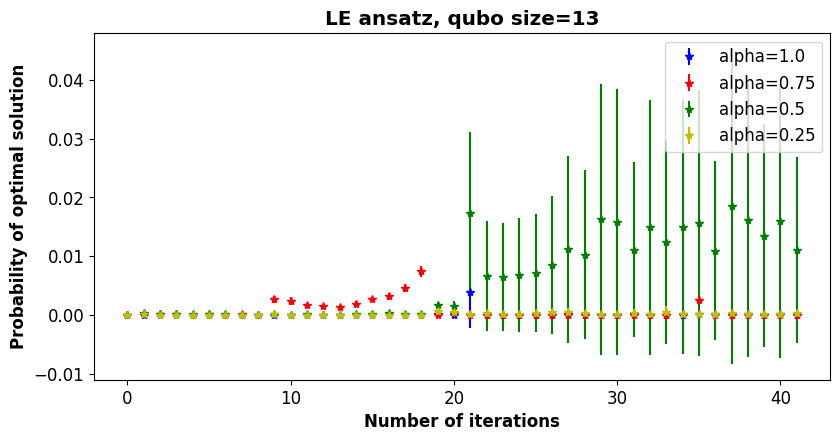

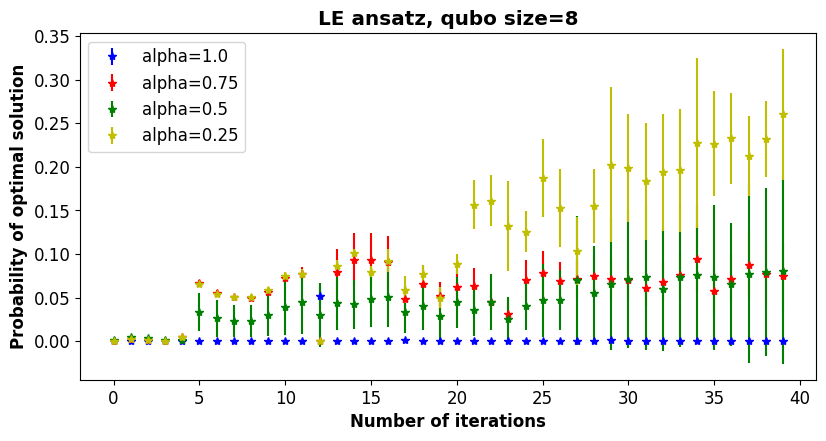

In [11]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

c = ['b', 'r', 'g', 'y', 'c']

for slice in range(6):
    plt.figure()
    for i in range(len(alphas)):
        number_of_iterations_linear = list(range(len(prob_opt_sol_linear_peralpha[i][slice][0])))
        errorbar_linear = np.std(prob_opt_sol_linear_peralpha[i][slice], axis=0)
        plt.errorbar(number_of_iterations_linear, np.mean(prob_opt_sol_linear_peralpha[i][slice], axis=0), yerr=errorbar_linear, fmt=f'*{c[i]}', label=f'alpha={alphas[i]}')

    plt.legend()
    plt.title(f'LE ansatz, qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')

## Comparison QAOA and LE ansatz for fixed alpha

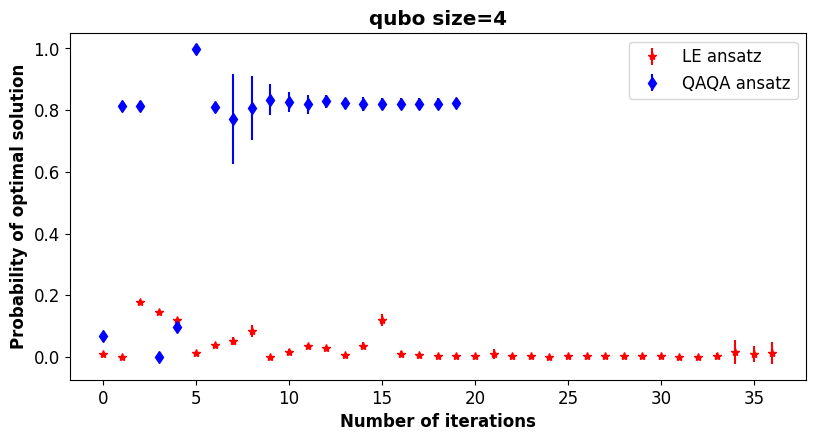

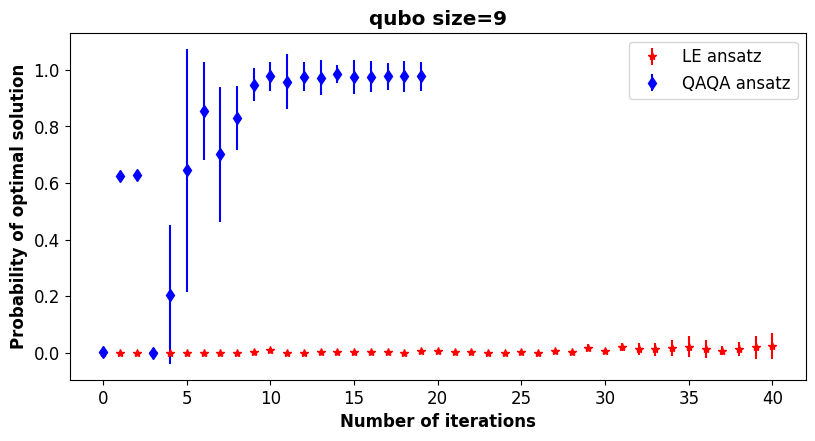

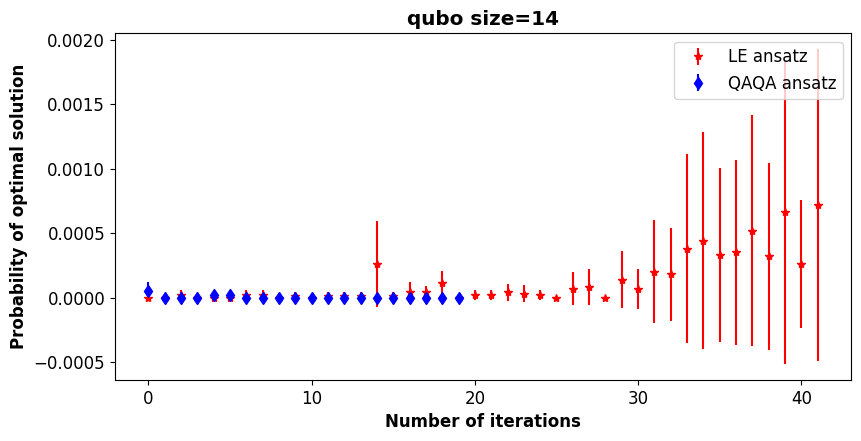

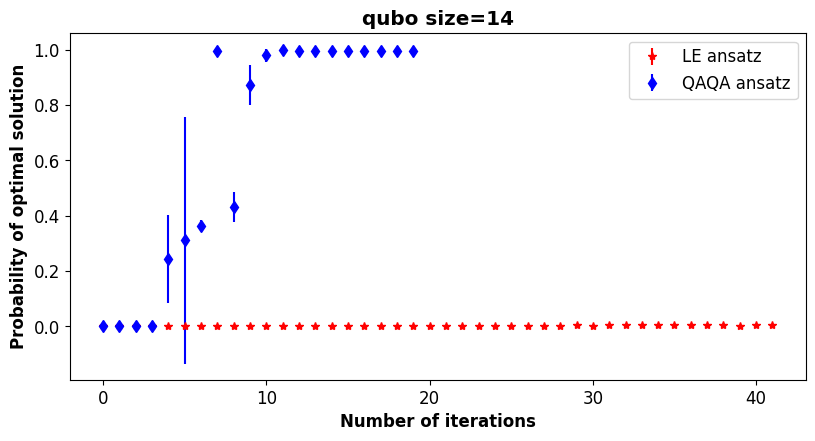

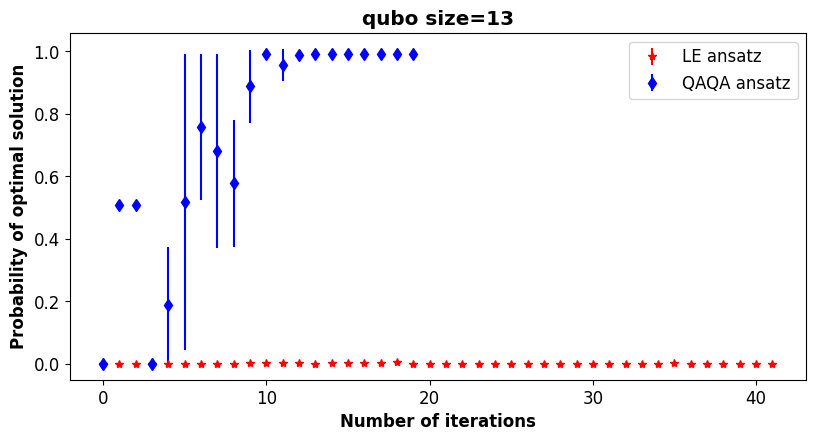

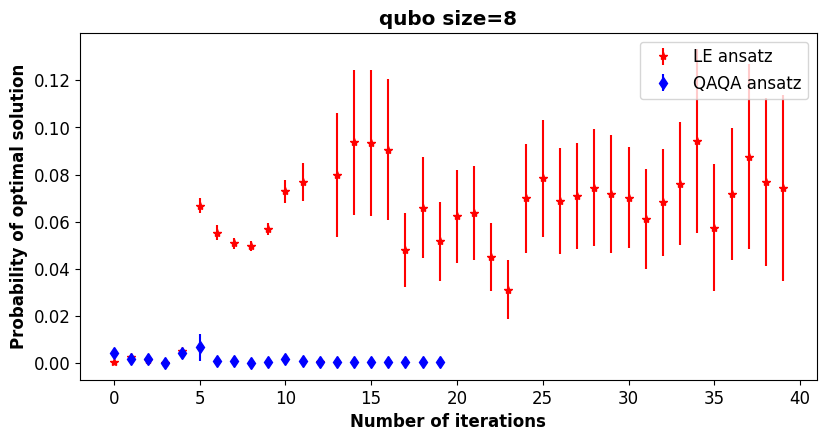

In [12]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

for slice in range(6):
    alpha_idx = -3
    number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa_peralpha[alpha_idx][slice][0])))
    number_of_iterations_linear = list(range(len(prob_opt_sol_linear_peralpha[alpha_idx][slice][0])))
    errorbar_linear = np.std(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0)
    errorbar_qaoa = np.std(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0)

    plt.figure()
    plt.errorbar(number_of_iterations_linear, np.mean(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_linear, fmt='*r', label='LE ansatz')
    plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_qaoa, fmt='db', label='QAQA ansatz')
    plt.legend()
    plt.title(f'qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')

In [13]:
# extract the probability of optimal solution from the results
cumulative_qaoa_peralpha = []
cumulative_linear_peralpha = []
for k in range(len(alphas)):
    cumulative_qaoa = []

    for slice in range(6):
        L = len(res_qaoa_slices_peralpha[k][slice][0])
        cumulative_perslice = np.zeros((num_mc, L))
        for i in range(num_mc):
            for j in range(len(res_qaoa_slices_peralpha[k][slice][i])): 
                if res_qaoa_slices_peralpha[k][slice][i][j][0] == optimal_solutions[slice][0]:
                    cumulative_perslice[i][j] += res_qaoa_slices_peralpha[k][slice][i][j][1]

        cumulative_qaoa.append(np.cumsum(cumulative_perslice, axis=1)/np.array([1+i for i in range(L)]))

    cumulative_linear = []

    for slice in range(6):
        L = len(res_linear_slices_peralpha[k][slice][0])
        cumulative_perslice = np.zeros((num_mc, L))
        for i in range(num_mc):
            for j in range(len(res_linear_slices_peralpha[k][slice][i])):
                if res_linear_slices_peralpha[k][slice][i][j][0] == optimal_solutions[slice][0]:
                    cumulative_perslice[i][j] += res_linear_slices_peralpha[k][slice][i][j][1]

        cumulative_linear.append(np.cumsum(cumulative_perslice, axis=1)/np.array([1+i for i in range(L)]))
    cumulative_linear_peralpha.append(cumulative_linear)
    cumulative_qaoa_peralpha.append(cumulative_qaoa)

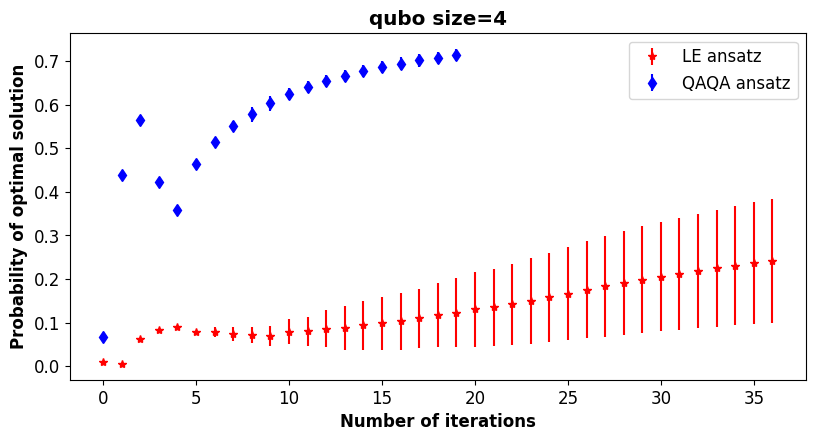

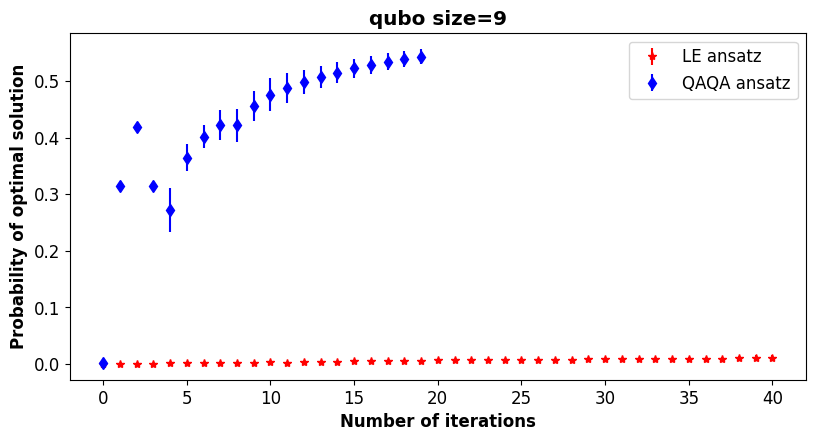

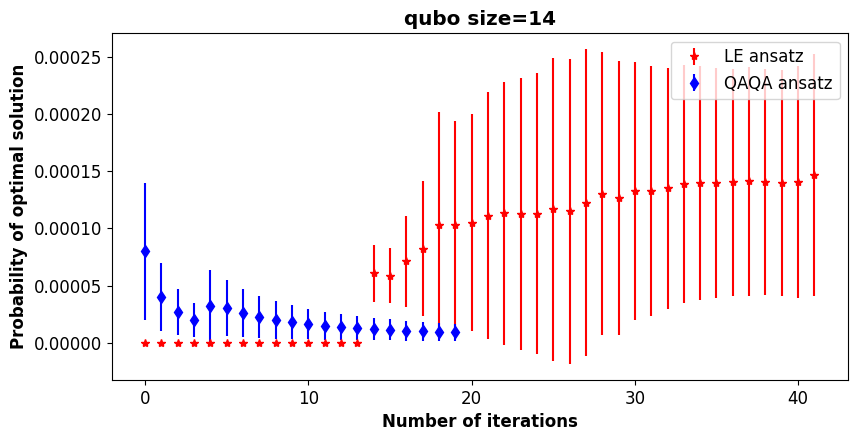

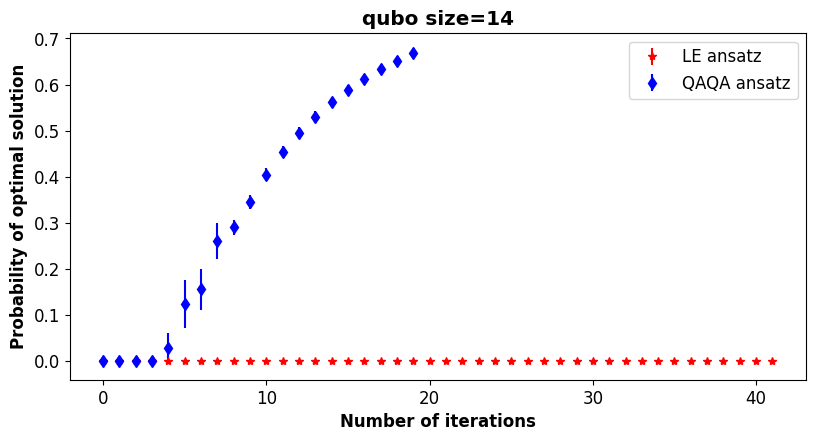

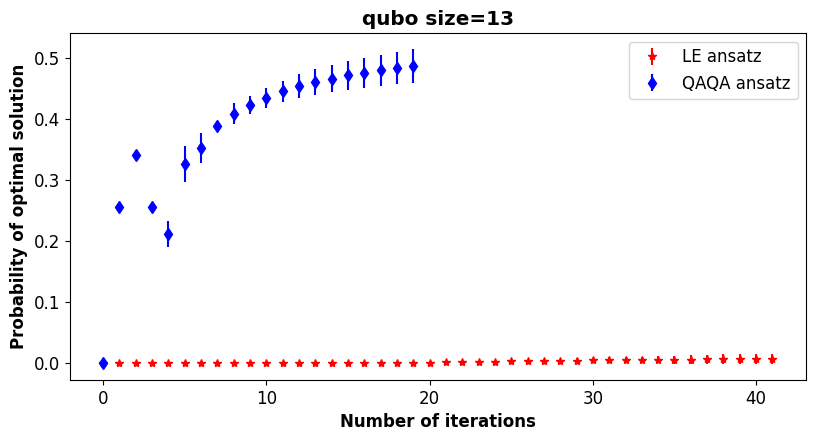

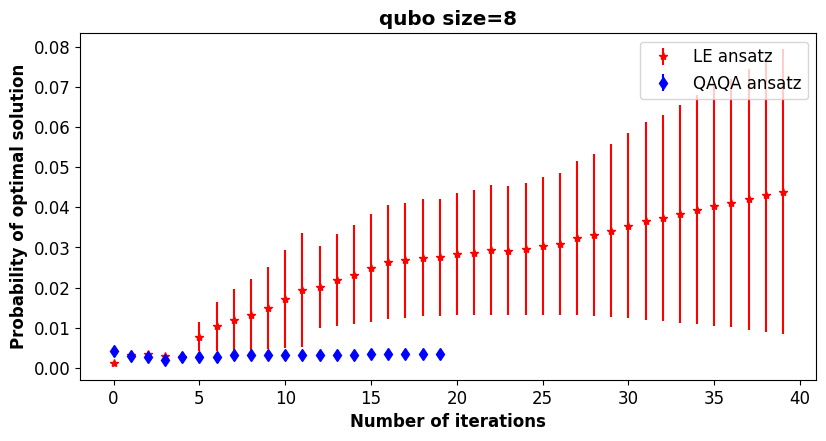

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

for slice in range(6):
    alpha_idx = 2
    number_of_iterations_qaoa = list(range(len(cumulative_qaoa_peralpha[alpha_idx][slice][0])))
    number_of_iterations_linear = list(range(len(cumulative_linear_peralpha[alpha_idx][slice][0])))
    errorbar_linear = np.std(cumulative_linear_peralpha[alpha_idx][slice], axis=0)
    errorbar_qaoa = np.std(cumulative_qaoa_peralpha[alpha_idx][slice], axis=0)

    plt.figure()
    plt.errorbar(number_of_iterations_linear, np.mean(cumulative_linear_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_linear, fmt='*r', label='LE ansatz')
    plt.errorbar(number_of_iterations_qaoa, np.mean(cumulative_qaoa_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_qaoa, fmt='db', label='QAQA ansatz')
    plt.legend()
    plt.title(f'qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')

## Resources required for quantum advantage

In [15]:
resources_qaoa_per_slice = []
resources_linear_per_slice = []

for slice, (qubo, ising_ham) in enumerate(q.qubo_hamiltonian_pairs):
    alpha_idx=2
    num_qubits = len(qubo)

    qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)
    le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
    resources_qaoa, resources_linear = total_gates(qaoa_ansatz), total_gates(le_ansatz)

    iter_factor = (resources_qaoa[1]/resources_linear[1]) * (resources_qaoa[2]/resources_linear[2])
    maxiter_qaoa = maxiter
    maxiter_linear = int(maxiter_qaoa * iter_factor)

    prob_qaoa = np.mean(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0)[-1]
    prob_linear = np.mean(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0)[-1]

    resources_qaoa_per_slice.append({'num_qubits': num_qubits, 'total_gates': resources_qaoa[0], 'depth': resources_qaoa[1], 'num_params': resources_qaoa[2], 'num_iterations': maxiter_qaoa, 'prob optimal solution': prob_qaoa})
    resources_linear_per_slice.append({'num_qubits': num_qubits, 'total_gates': resources_linear[0], 'depth': resources_linear[1], 'num_params': resources_linear[2], 'num_iterations': maxiter_linear, 'prob optimal solution': prob_linear})


In [16]:
import pandas as pd

qaoa_df = pd.DataFrame(resources_qaoa_per_slice)
qaoa_df


,num_qubits,total_gates,depth,num_params,num_iterations,prob optimal solution
0,4,48,38,2,20,0.82274
1,9,243,187,2,20,0.62605
2,14,588,448,2,20,0.00000
3,14,588,448,2,20,0.99249
4,13,507,387,2,20,0.54880
5,8,192,148,2,20,0.00403


In [17]:
linear_df = pd.DataFrame(resources_linear_per_slice)
linear_df

,num_qubits,total_gates,depth,num_params,num_iterations,prob optimal solution
0,4,11,5,8,38,0.42237
1,9,26,10,18,41,0.02626
2,14,41,15,28,42,0.00039
3,14,41,15,28,42,0.00060
4,13,38,14,26,42,0.01108
5,8,23,9,16,41,0.08061


## Probability of eps-optimal solutions
If $E_0$ is the ground energy, we want to consider all the bitstrings with energy $E$ such that $E\leq 0.9\cdot E_0$ if $E_0<0$ and else $E\leq 1.1\cdot E_0$. That is, energies with a relative distance of 0.1 to the optimal energy.

In [23]:
np.random.seed(1)

# now we solve all the qubo's and output optimal bitstrings of for each slice using QAOA and twolocal ansatz
alphas = [1.0, 0.75, 0.5, 0.25]
maxiter = 30
num_mc = 5

res_qaoa_slices_peralpha = []
res_linear_slices_peralpha = []

# If you haved the data from a previous run, set this to true. Else set it to false and it will run and save the data.
saved_data = False

if not saved_data:
    for alpha in alphas:
        print(f'alpha={alpha}')
        res_qaoa_slices = []
        res_linear_slices = []

        i = 0

        for qubo, ising_ham in q.qubo_hamiltonian_pairs:
            num_qubits = len(qubo)

            res_qaoa = []
            res_linear = []
            # print(f"slice {i}")
            i+=1
            
            # define the ansatzes
            # qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)
            qaoa_ansatz = QAOA_ansatz(qubo=qubo)
            beta  = [0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
            gamma = [0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
            params_qaoa = np.array(beta+gamma)

            # LE ansatz circuit
            le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
            params_linear = np.array([np.random.random()]*le_ansatz.num_parameters)

            # to keep it fair, we want depth * number_of_params * maxiter to be the same for both instances
            resources_qaoa, resources_linear = total_gates(qaoa_ansatz), total_gates(le_ansatz)
            iter_factor = (resources_qaoa[1]/resources_linear[1]) * (resources_qaoa[2]/resources_linear[2])
            maxiter_qaoa = maxiter
            maxiter_linear = int(maxiter_qaoa * iter_factor)

            histories_qaoa = []
            histories_linear = []

            vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params_qaoa, prob_opt_sol=False)
            for _ in range(num_mc):
                vqe_qaoa.params = params_qaoa
                vqe_qaoa.history = []

                vqe_qaoa.run(alpha=alpha, maxiter=maxiter_qaoa)
                history = vqe_qaoa.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter_qaoa-L):
                    history.append(last)

                histories_qaoa.append(history)

            vqe_linear = VQE(qubo=qubo, ansatz=le_ansatz, sampler=sampler, params=params_linear, prob_opt_sol=False)
            for _ in range(num_mc):
                vqe_linear.params = params_linear
                vqe_linear.history = []

                vqe_linear.run(alpha=alpha, maxiter=maxiter_linear)
                history = vqe_linear.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter_linear-L):
                    history.append(last)

                histories_linear.append(history)
                
            res_qaoa_slices.append(histories_qaoa)
            res_linear_slices.append(histories_linear)
        res_qaoa_slices_peralpha.append(res_qaoa_slices)
        res_linear_slices_peralpha.append(res_linear_slices)

    with open('qaoa_linear_relative_res_ws.pkl', 'wb') as handle:
            pickle.dump((res_qaoa_slices_peralpha, res_linear_slices_peralpha, alphas), handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(f'qaoa_linear_relative_res_ws.pkl', 'rb') as handle:
        a = pickle.load(handle)
        res_qaoa_slices_peralpha, res_linear_slices_peralpha = a[0], a[1]

alpha=1.0
alpha=0.75
alpha=0.5
alpha=0.25


In [24]:
# extract the probability of optimal solution from the results
prob_opt_sol_qaoa_peralpha = []
prob_opt_sol_linear_peralpha = []
for k in range(len(alphas)):
    prob_opt_sol_qaoa = []

    for slice in range(6):
        probs_perslice = np.zeros((num_mc, len(res_qaoa_slices_peralpha[k][slice][0])))
        for i in range(num_mc):
            for j in range(len(res_qaoa_slices_peralpha[k][slice][i])):
                probs_perslice[i][j] = res_qaoa_slices_peralpha[k][slice][i][j][0]

        prob_opt_sol_qaoa.append(probs_perslice)

    prob_opt_sol_linear = []

    for slice in range(6):
        probs_perslice = np.zeros((num_mc, len(res_linear_slices_peralpha[k][slice][0])))
        for i in range(num_mc):
            for j in range(len(res_linear_slices_peralpha[k][slice][i])):
                probs_perslice[i][j] = res_linear_slices_peralpha[k][slice][i][j][0]

        prob_opt_sol_linear.append(probs_perslice)
    prob_opt_sol_linear_peralpha.append(prob_opt_sol_linear)
    prob_opt_sol_qaoa_peralpha.append(prob_opt_sol_qaoa)

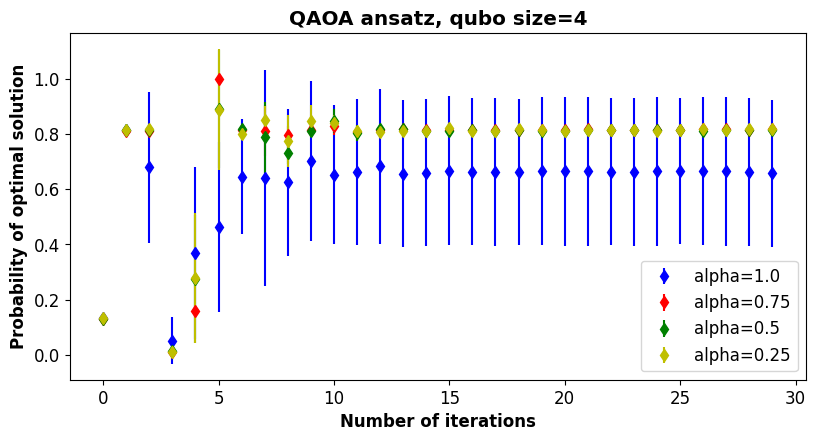

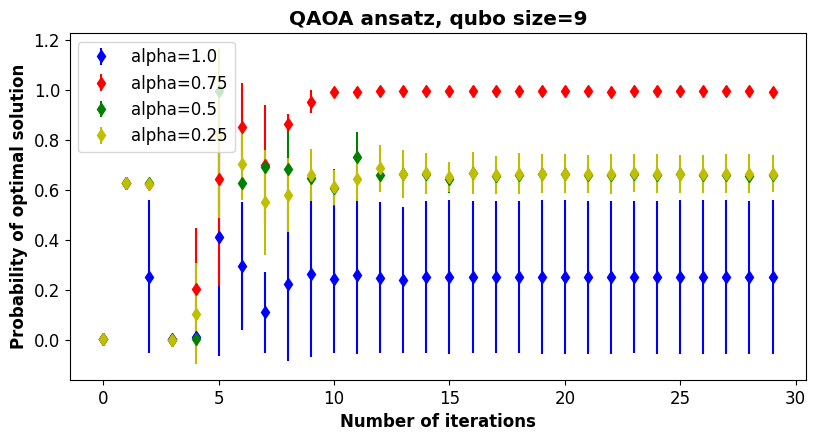

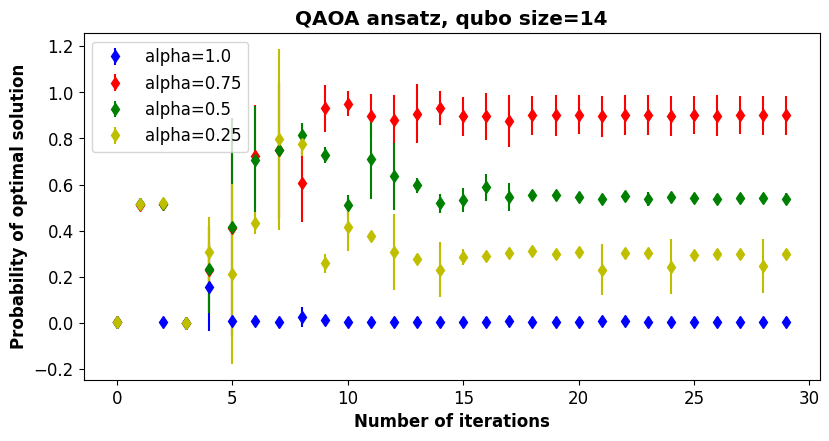

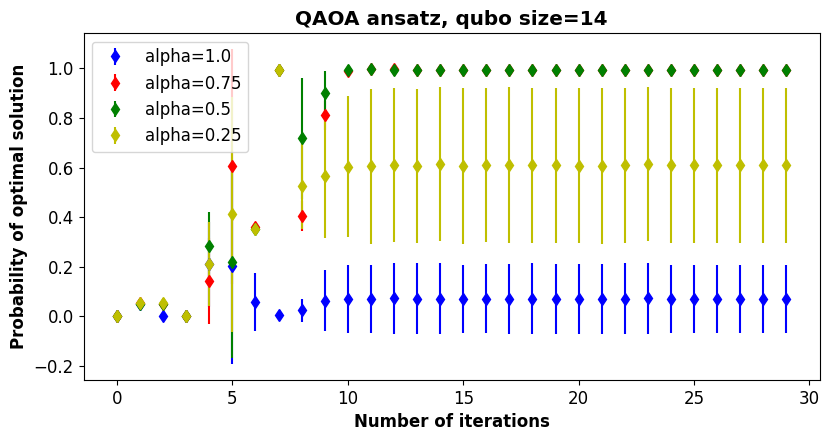

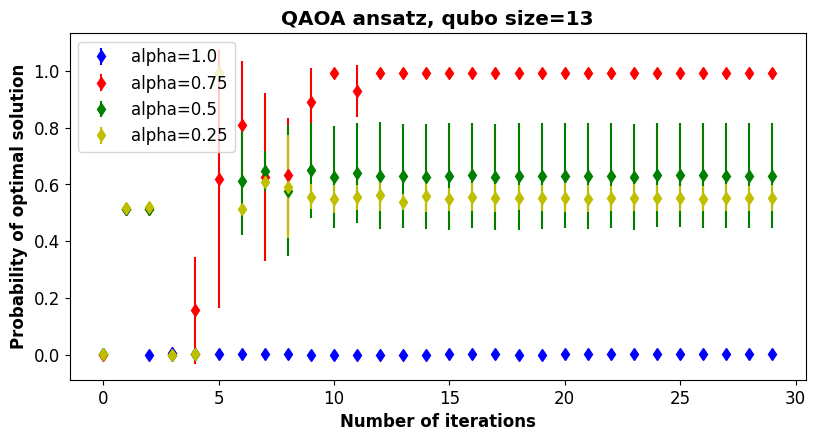

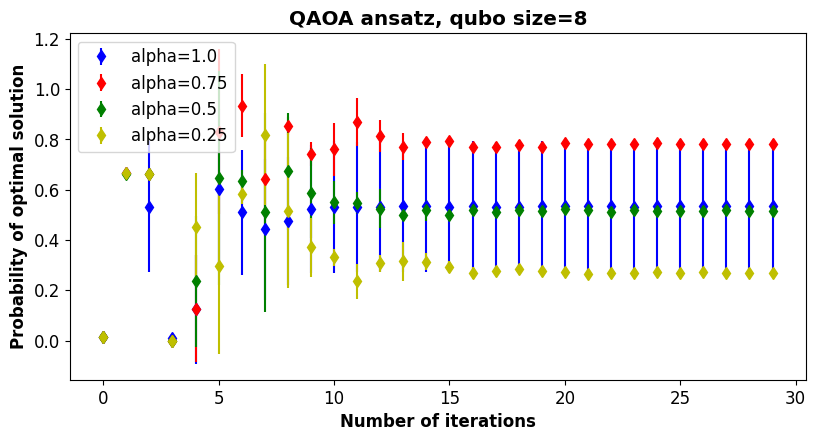

In [25]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

c = ['b', 'r', 'g', 'y', 'c']

for slice in range(6):
    plt.figure()
    for i in range(len(alphas)):
        number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa_peralpha[i][slice][0])))
        errorbar_qaoa = np.std(prob_opt_sol_qaoa_peralpha[i][slice], axis=0)
        plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa_peralpha[i][slice], axis=0), yerr=errorbar_qaoa, fmt=f'd{c[i]}', label=f'alpha={alphas[i]}')

    plt.legend()
    plt.title(f'QAOA ansatz, qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')


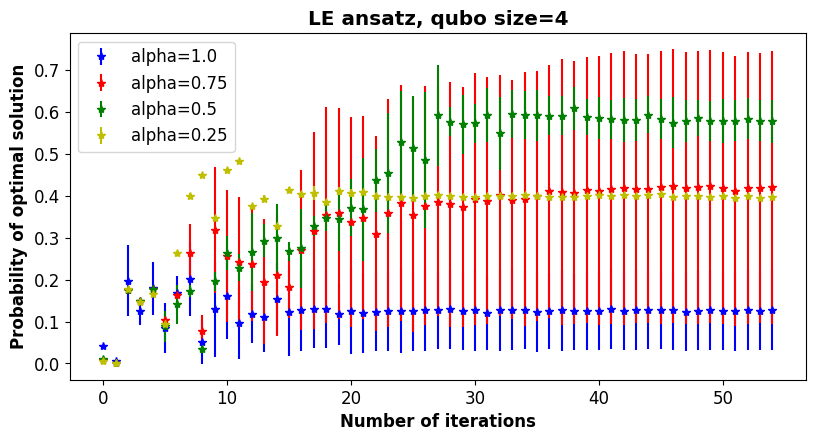

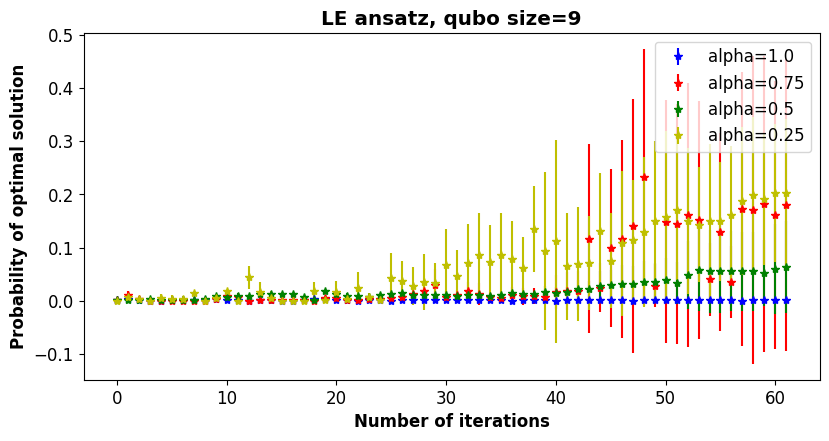

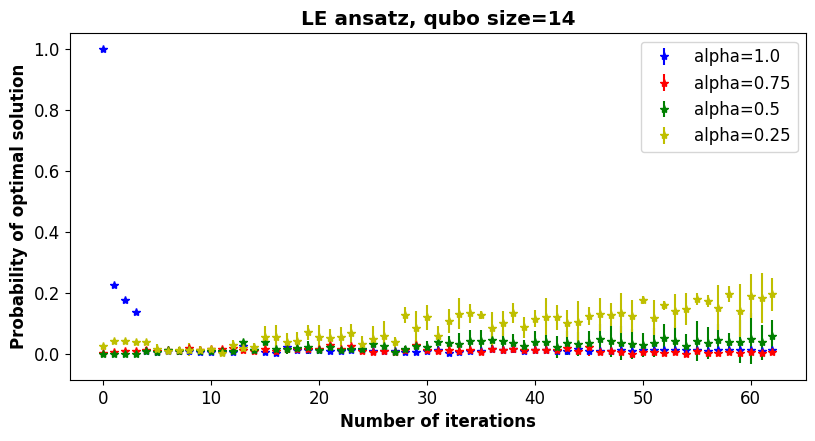

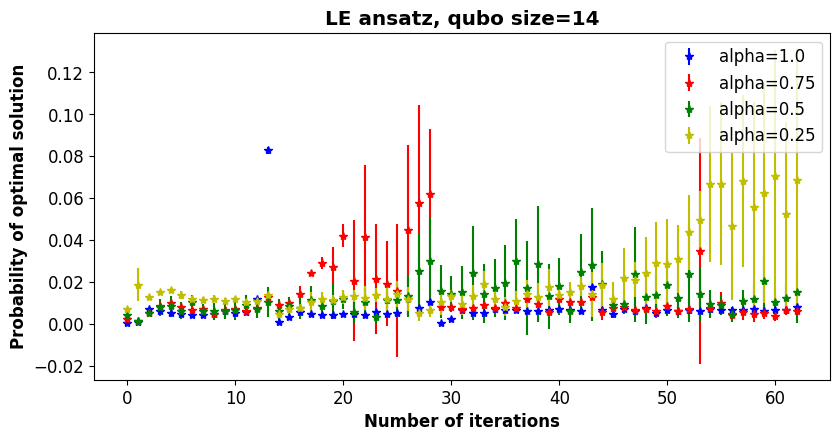

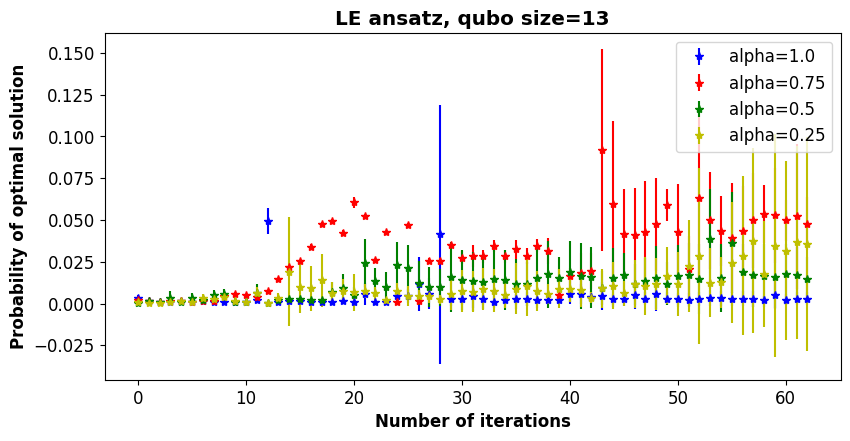

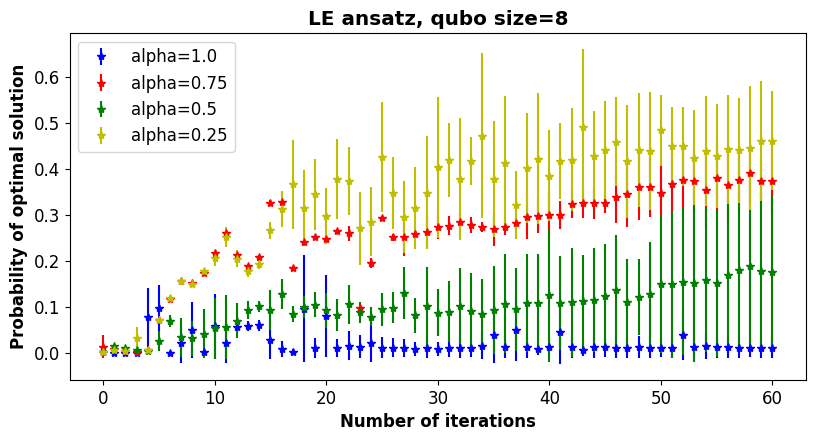

In [26]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

c = ['b', 'r', 'g', 'y', 'c']

for slice in range(6):
    plt.figure()
    for i in range(len(alphas)):
        number_of_iterations_linear = list(range(len(prob_opt_sol_linear_peralpha[i][slice][0])))
        errorbar_linear = np.std(prob_opt_sol_linear_peralpha[i][slice], axis=0)
        plt.errorbar(number_of_iterations_linear, np.mean(prob_opt_sol_linear_peralpha[i][slice], axis=0), yerr=errorbar_linear, fmt=f'*{c[i]}', label=f'alpha={alphas[i]}')

    plt.legend()
    plt.title(f'LE ansatz, qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')

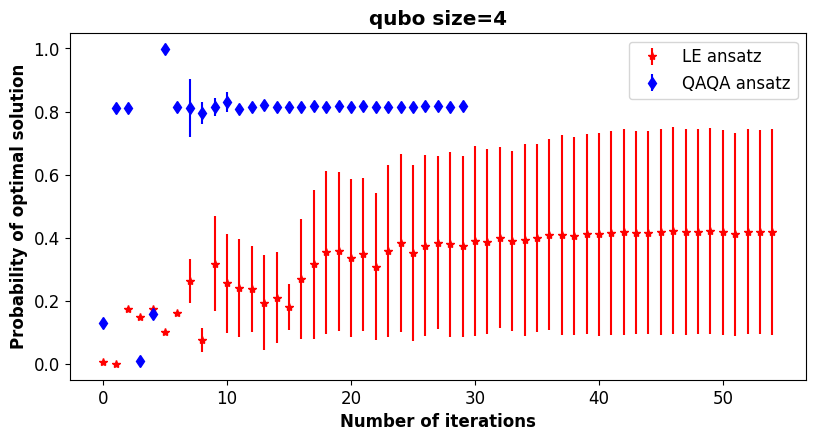

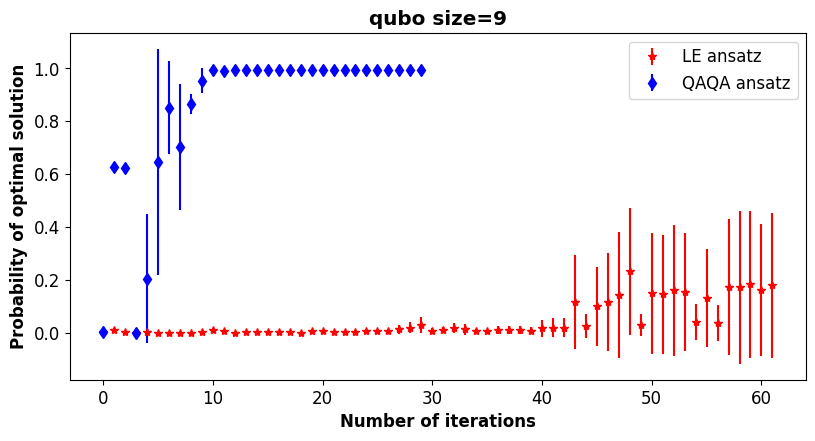

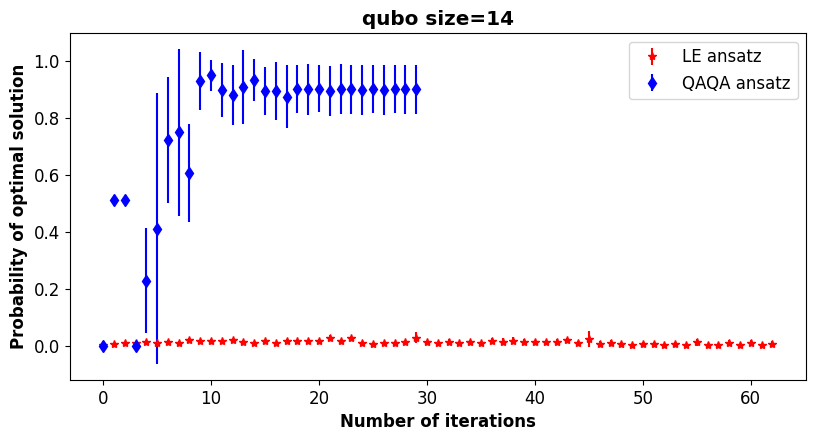

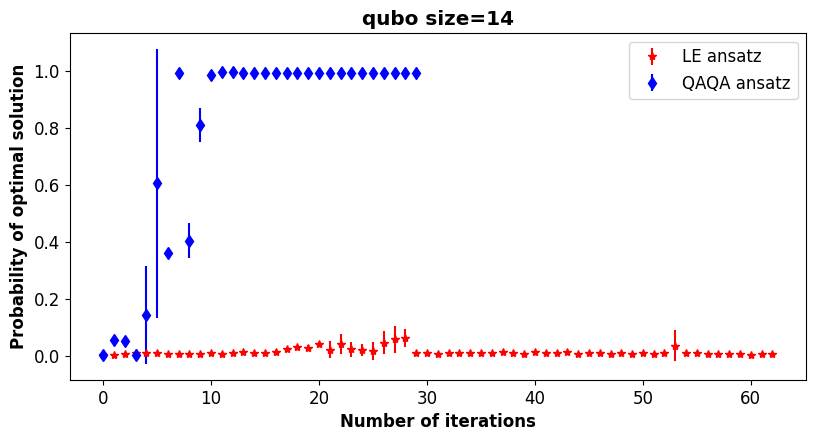

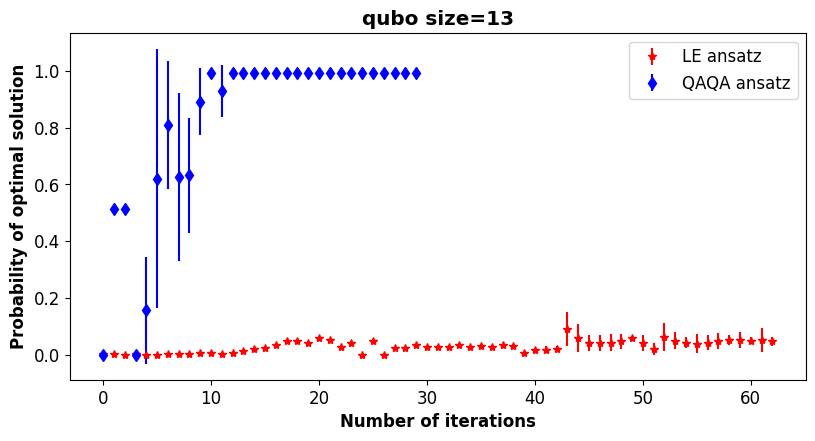

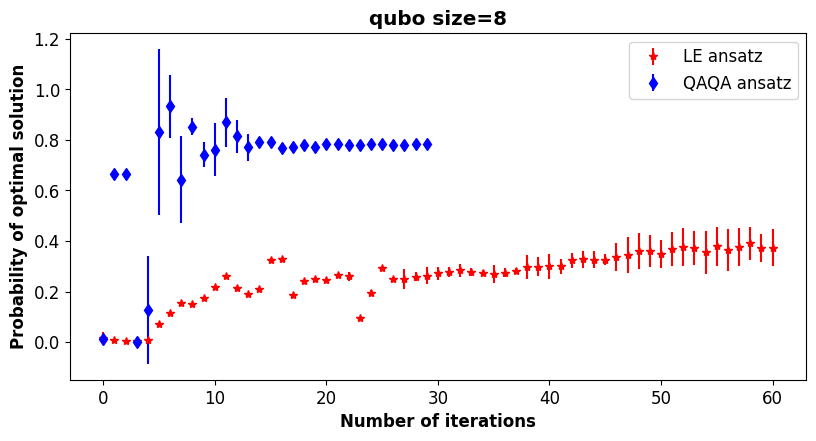

In [27]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

for slice in range(6):
    alpha_idx = -3
    number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa_peralpha[alpha_idx][slice][0])))
    number_of_iterations_linear = list(range(len(prob_opt_sol_linear_peralpha[alpha_idx][slice][0])))
    errorbar_linear = np.std(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0)
    errorbar_qaoa = np.std(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0)

    plt.figure()
    plt.errorbar(number_of_iterations_linear, np.mean(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_linear, fmt='*r', label='LE ansatz')
    plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_qaoa, fmt='db', label='QAQA ansatz')
    plt.legend()
    plt.title(f'qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')